In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [2]:
data_df = pd.read_csv('bestbuy_train_val_data_classify_price.csv', index_col=False)
data_df.head()

,Price,Key_Specs__Screen_Size,Key_Specs__Touch_Screen,Key_Specs__Storage_Type,Key_Specs__System_Memory,RAM_type,RAM_speed,Processor,Graphics__Graphics,Screen_resolution1,...,Feature__Backlit_Keyboard,Feature__Mac_Features,Port_Number_USB_Ports,Display__Display_Type,Storage__eMMC_Capacity,Storage__Solid_State_Drive_Capacity,Dimension__Product_Depth,Dimension__Product_Height,Dimension__Product_Weight,Dimension__Product_Width
0,1,13.3,yes,ssd,16.0,lpddr3,2133.0,intel 8th generation core i7,intel hd graphics 620,1920.0,...,yes,NaN,1.0,full hd widescreen led,0.0,512.0,8.6,0.4,2.43,12.3
1,0,11.6,no,emmc,4.0,lpddr4,2400.0,intel celeron,intel uhd graphics 600,1366.0,...,no,NaN,4.0,lcd,16.0,0.0,8.2,0.8,2.84,12.0
2,1,14.0,yes,ssd,12.0,ddr4 sdram,2666.0,intel 10th generation core i7,other,1920.0,...,yes,NaN,2.0,full hd widescreen led,0.0,512.0,8.9,0.6,3.59,12.7
3,2,15.6,no,"ssd, hdd",16.0,ddr4 sdram,2666.0,intel 8th generation core i7,other,1920.0,...,yes,NaN,3.0,full hd widescreen led,0.0,512.0,9.7,1.0,5.29,14.2
4,0,11.6,no,emmc,4.0,lpddr3,NaN,intel celeron,intel hd graphics 400,1366.0,...,no,NaN,2.0,led-lcd,32.0,0.0,8.3,0.9,2.87,11.7


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 26 columns):
Price                                  936 non-null int64
Key_Specs__Screen_Size                 936 non-null float64
Key_Specs__Touch_Screen                927 non-null object
Key_Specs__Storage_Type                920 non-null object
Key_Specs__System_Memory               927 non-null float64
RAM_type                               927 non-null object
RAM_speed                              610 non-null float64
Processor                              927 non-null object
Graphics__Graphics                     910 non-null object
Screen_resolution1                     934 non-null float64
Screen_resolution2                     934 non-null float64
Key_Specs__Operating_System            923 non-null object
Key_Specs__Battery_Type                936 non-null object
General__Color_Category                936 non-null object
General__Brand                         934 non-null object
Featur

# Split Data

In [4]:
y_sr = data_df['Price']
X_df = data_df.drop('Price', axis=1)

In [5]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.15, random_state=0)

In [6]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 5 to 684
Data columns (total 25 columns):
Key_Specs__Screen_Size                 795 non-null float64
Key_Specs__Touch_Screen                786 non-null object
Key_Specs__Storage_Type                780 non-null object
Key_Specs__System_Memory               786 non-null float64
RAM_type                               786 non-null object
RAM_speed                              521 non-null float64
Processor                              786 non-null object
Graphics__Graphics                     773 non-null object
Screen_resolution1                     793 non-null float64
Screen_resolution2                     793 non-null float64
Key_Specs__Operating_System            782 non-null object
Key_Specs__Battery_Type                795 non-null object
General__Color_Category                795 non-null object
General__Brand                         793 non-null object
Feature__Keyboard_Touch_Screen         601 non-null object
Featu

# Transform data

In [7]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        transformed_X_df = X_df.copy()
        transformed_X_df = transformed_X_df.drop([], axis=1)
        return transformed_X_df

In [8]:
# data_df = pd.read_csv('train_val_data.csv', index_col=False)
# train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.15, random_state=0)
# col_adderdropper = ColAdderDropper()
# train_X_df = col_adderdropper.fit_transform(train_X_df)
# val_X_df = col_adderdropper.fit_transform(val_X_df)
# train_X_df.isna().values.sum()

In [9]:
class FillNA(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fillna_values = {}
    def fit(self, X_df, y=None):
        self.fillna_values['Key_Specs__Screen_Size'] = X_df['Key_Specs__Screen_Size'].mean()
        self.fillna_values['Key_Specs__System_Memory'] = X_df['Key_Specs__System_Memory'].mean()
        self.fillna_values['RAM_speed'] = X_df['RAM_speed'].mean()
        self.fillna_values['Screen_resolution1'] = X_df['Screen_resolution1'].mean()
        self.fillna_values['Screen_resolution2'] = X_df['Screen_resolution2'].mean()
        self.fillna_values['Port_Number_USB_Ports'] = X_df['Port_Number_USB_Ports'].mean()
        self.fillna_values['Storage__eMMC_Capacity'] = X_df['Storage__eMMC_Capacity'].mean()
        self.fillna_values['Storage__Solid_State_Drive_Capacity'] = X_df['Storage__Solid_State_Drive_Capacity'].mean()
        self.fillna_values['Dimension__Product_Depth'] = X_df['Dimension__Product_Depth'].mean()
        self.fillna_values['Dimension__Product_Height'] = X_df['Dimension__Product_Height'].mean()
        self.fillna_values['Dimension__Product_Weight'] = X_df['Dimension__Product_Weight'].mean()
        self.fillna_values['Dimension__Product_Width'] = X_df['Dimension__Product_Width'].mean()
        
        self.fillna_values['Key_Specs__Touch_Screen'] = X_df['Key_Specs__Touch_Screen'].mode()[0]
        self.fillna_values['Key_Specs__Storage_Type'] = X_df['Key_Specs__Storage_Type'].mode()[0]
        self.fillna_values['RAM_type'] = X_df['RAM_type'].mode()[0]
        self.fillna_values['Processor'] = X_df['Processor'].mode()[0]
        self.fillna_values['Graphics__Graphics'] = X_df['Graphics__Graphics'].mode()[0]
        self.fillna_values['Key_Specs__Operating_System'] = X_df['Key_Specs__Operating_System'].mode()[0]
        self.fillna_values['Key_Specs__Battery_Type'] = X_df['Key_Specs__Battery_Type'].mode()[0]#'Others'
        self.fillna_values['General__Color_Category'] = X_df['General__Color_Category'].mode()[0]
        self.fillna_values['General__Brand'] = X_df['General__Brand'].mode()[0]
        self.fillna_values['Feature__Keyboard_Touch_Screen'] = X_df['Feature__Keyboard_Touch_Screen'].mode()[0]
        self.fillna_values['Feature__Backlit_Keyboard'] = X_df['Feature__Backlit_Keyboard'].mode()[0]
        self.fillna_values['Feature__Mac_Features'] = X_df['Feature__Mac_Features'].mode()[0]#'Others'
        self.fillna_values['Display__Display_Type'] = X_df['Display__Display_Type'].mode()[0]
            
        return self
    
    def transform(self, X_df, y=None):
        transformed_X_df = X_df.copy()
        
        transformed_X_df['Key_Specs__Screen_Size'].fillna(value=self.fillna_values['Key_Specs__Screen_Size'], inplace=True)
        transformed_X_df['Key_Specs__System_Memory'].fillna(value=self.fillna_values['Key_Specs__System_Memory'], inplace=True)
        transformed_X_df['RAM_speed'].fillna(value=self.fillna_values['RAM_speed'], inplace=True)
        transformed_X_df['Screen_resolution1'].fillna(value=self.fillna_values['Screen_resolution1'], inplace=True)
        transformed_X_df['Screen_resolution2'].fillna(value=self.fillna_values['Screen_resolution2'], inplace=True)
        transformed_X_df['Port_Number_USB_Ports'].fillna(value=self.fillna_values['Port_Number_USB_Ports'], inplace=True)
        transformed_X_df['Storage__eMMC_Capacity'].fillna(value=self.fillna_values['Storage__eMMC_Capacity'], inplace=True)
        transformed_X_df['Storage__Solid_State_Drive_Capacity'].fillna(value=self.fillna_values['Storage__Solid_State_Drive_Capacity'], inplace=True)
        transformed_X_df['Dimension__Product_Depth'].fillna(value=self.fillna_values['Dimension__Product_Depth'], inplace=True)
        transformed_X_df['Dimension__Product_Height'].fillna(value=self.fillna_values['Dimension__Product_Height'], inplace=True)
        transformed_X_df['Dimension__Product_Weight'].fillna(value=self.fillna_values['Dimension__Product_Weight'], inplace=True)
        transformed_X_df['Dimension__Product_Width'].fillna(value=self.fillna_values['Dimension__Product_Width'], inplace=True)
        
        transformed_X_df['Key_Specs__Touch_Screen'].fillna(value=self.fillna_values['Key_Specs__Touch_Screen'], inplace=True)
        transformed_X_df['Key_Specs__Storage_Type'].fillna(value=self.fillna_values['Key_Specs__Storage_Type'], inplace=True)
        transformed_X_df['RAM_type'].fillna(value=self.fillna_values['RAM_type'], inplace=True)
        transformed_X_df['Processor'].fillna(value=self.fillna_values['Processor'], inplace=True)
        transformed_X_df['Graphics__Graphics'].fillna(value=self.fillna_values['Graphics__Graphics'], inplace=True)
        transformed_X_df['Key_Specs__Operating_System'].fillna(value=self.fillna_values['Key_Specs__Operating_System'], inplace=True)
        transformed_X_df['Key_Specs__Battery_Type'].fillna(value=self.fillna_values['Key_Specs__Battery_Type'], inplace=True)
        transformed_X_df['General__Color_Category'].fillna(value=self.fillna_values['General__Color_Category'], inplace=True)
        transformed_X_df['General__Brand'].fillna(value=self.fillna_values['General__Brand'], inplace=True)
        transformed_X_df['Feature__Keyboard_Touch_Screen'].fillna(value=self.fillna_values['Feature__Keyboard_Touch_Screen'], inplace=True)
        transformed_X_df['Feature__Backlit_Keyboard'].fillna(value=self.fillna_values['Feature__Backlit_Keyboard'], inplace=True)
        transformed_X_df['Feature__Mac_Features'].fillna(value=self.fillna_values['Feature__Mac_Features'], inplace=True)
        transformed_X_df['Display__Display_Type'].fillna(value=self.fillna_values['Display__Display_Type'], inplace=True)
        
        return transformed_X_df

In [10]:
# fillNa = FillNA()
# fillNa.fit(train_X_df)
# train_X_df = fillNa.transform(train_X_df)
# train_X_df.info()

In [11]:
# val_X_df = fillNa.transform(val_X_df)
# val_X_df.info()

In [12]:
# train_X_df['BrandName'].isna().values.sum()

In [13]:
# val_X_df['BrandName'].value_counts()

# Full Pipeline - Train

In [14]:
numeric_cols = ['Key_Specs__Screen_Size', 'Key_Specs__System_Memory', 'RAM_speed', 'Screen_resolution1', 'Screen_resolution2', 
                'Port_Number_USB_Ports', 'Storage__eMMC_Capacity', 'Storage__Solid_State_Drive_Capacity', 'Dimension__Product_Depth',
               'Dimension__Product_Height', 'Dimension__Product_Weight', 'Dimension__Product_Width']
category_cols = ['Key_Specs__Touch_Screen', 'Key_Specs__Storage_Type', 'RAM_type', 'Processor',
                 'Graphics__Graphics', 'Key_Specs__Operating_System', 'Key_Specs__Battery_Type', 'General__Color_Category',
                 'General__Brand', 'Feature__Keyboard_Touch_Screen', 'Feature__Backlit_Keyboard',
                'Feature__Mac_Features', 'Display__Display_Type']

numeric_imputer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
category_imputer = Pipeline([('one_hot_vector', OneHotEncoder(handle_unknown='ignore'))])

transform_cols = ColumnTransformer([('category_imputer', category_imputer, category_cols)])
reprocess_pipeline = Pipeline([('coladderdropper', ColAdderDropper()), ('fill_na', FillNA()), ('transform_cols', transform_cols), ('std_scaler', StandardScaler(with_mean=False))])

# Logistic regression

In [27]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=500, verbose=0, n_jobs=4, random_state=0)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('logistic_regression', logistic_regression)])

max_iter = [20, 40, 50, 100, 200, 300, 500, 1000]
for iter_ in max_iter:
    full_pipeline.set_params(logistic_regression__max_iter=iter_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('MaxIter: %f - Train acc: %f - Val acc: %f' %(iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

MaxIter: 20.000000 - Train acc: 0.909434 - Val acc: 0.737589
MaxIter: 40.000000 - Train acc: 0.920755 - Val acc: 0.758865
MaxIter: 50.000000 - Train acc: 0.930818 - Val acc: 0.765957
MaxIter: 100.000000 - Train acc: 0.925786 - Val acc: 0.758865
MaxIter: 200.000000 - Train acc: 0.927044 - Val acc: 0.751773
MaxIter: 300.000000 - Train acc: 0.924528 - Val acc: 0.758865
MaxIter: 500.000000 - Train acc: 0.924528 - Val acc: 0.758865
MaxIter: 1000.000000 - Train acc: 0.924528 - Val acc: 0.758865


# MLPClassifier

In [26]:
mlp_classifier = MLPClassifier((40), 'tanh', 'lbfgs', max_iter=200, random_state=0, verbose=False)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('mlp_classifier', mlp_classifier)])

alphas = [0.1, 1, 10]
max_iter = [200, 500, 1000]
for alpha in alphas:
    for iter_ in max_iter:
        full_pipeline.set_params(mlp_classifier__alpha=alpha, mlp_classifier__max_iter=iter_)
        full_pipeline.fit(train_X_df, train_y_sr)
        print('Alpha: %f - MaxIter: %f - Train acc: %f - Val acc: %f' %(alpha, iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 0.100000 - MaxIter: 200.000000 - Train acc: 0.982390 - Val acc: 0.737589


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 0.100000 - MaxIter: 500.000000 - Train acc: 0.982390 - Val acc: 0.744681
Alpha: 0.100000 - MaxIter: 1000.000000 - Train acc: 0.982390 - Val acc: 0.737589


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 1.000000 - MaxIter: 200.000000 - Train acc: 0.982390 - Val acc: 0.758865


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 1.000000 - MaxIter: 500.000000 - Train acc: 0.982390 - Val acc: 0.765957
Alpha: 1.000000 - MaxIter: 1000.000000 - Train acc: 0.982390 - Val acc: 0.758865


c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha: 10.000000 - MaxIter: 200.000000 - Train acc: 0.962264 - Val acc: 0.744681
Alpha: 10.000000 - MaxIter: 500.000000 - Train acc: 0.962264 - Val acc: 0.751773
Alpha: 10.000000 - MaxIter: 1000.000000 - Train acc: 0.962264 - Val acc: 0.751773


# SVM

In [17]:
svm_ = svm.SVC(verbose=False, random_state=0, max_iter=100)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('svm', svm_)])

max_iter = [300, 500, 1000, 2000, 4000]
for iter_ in max_iter:
    full_pipeline.set_params(svm__max_iter=iter_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('MaxIter: %f - Train acc: %f - Val acc: %f' %(iter_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

c:\users\huynhnhut\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


MaxIter: 300.000000 - Train acc: 0.876730 - Val acc: 0.709220
MaxIter: 500.000000 - Train acc: 0.877987 - Val acc: 0.709220
MaxIter: 1000.000000 - Train acc: 0.877987 - Val acc: 0.709220
MaxIter: 2000.000000 - Train acc: 0.877987 - Val acc: 0.709220
MaxIter: 4000.000000 - Train acc: 0.877987 - Val acc: 0.709220


# Randomforest

In [18]:
random_forest = RandomForestClassifier(n_estimators=200, verbose=0, n_jobs=4, random_state=0, oob_score=True)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('random_forest', random_forest)])

n_estimators = [100, 200, 300]
for n_es_ in n_estimators:
    full_pipeline.set_params(random_forest__n_estimators=n_es_)
    full_pipeline.fit(train_X_df, train_y_sr)
    print('n_estimator: %d - Train acc: %f - Val acc: %f' %(n_es_, full_pipeline.score(train_X_df, train_y_sr), full_pipeline.score(val_X_df, val_y_sr)))

n_estimator: 100 - Train acc: 0.982390 - Val acc: 0.730496
n_estimator: 200 - Train acc: 0.982390 - Val acc: 0.723404
n_estimator: 300 - Train acc: 0.982390 - Val acc: 0.723404


# Test

In [19]:
test_data_df = pd.read_csv('bestbuy_test_data_classify_price.csv', index_col=False)

In [21]:
test_y_sr = test_data_df['Price']
test_X_df = test_data_df.drop('Price', axis=1)

In [28]:
test_model = LogisticRegression(solver='lbfgs', max_iter=50, verbose=0, n_jobs=4, random_state=0)
full_pipeline = Pipeline([('reprocess_data', reprocess_pipeline), ('test_model', test_model)])

fits = full_pipeline.fit(train_X_df, train_y_sr)
score = fits.score(test_X_df, test_y_sr)
score

0.8

[[34  3  0  0]
 [ 4 26  3  0]
 [ 0  5 14  3]
 [ 0  0  3 10]]


Text(0.5, 1, 'Accuracy Score: 0.8')

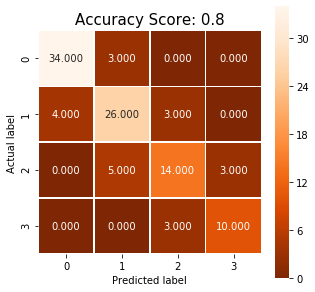

In [29]:
y_predicted = full_pipeline.predict(test_X_df)
cm = metrics.confusion_matrix(test_y_sr, y_predicted)
print(cm)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Oranges_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)